# model

## 환경 설정 [😉 이 코드는 반드시 실행하세요! 😉]
> 만약 구글 드라이브 마운트(Google Drive Mount)가 안되어있다면 꼭 마운트를 하고나서 진행한다! 
- 패키지 설치 및 임포트
- **실습을 위한 폴더 경로 설정** <- 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄
- 실습 자료 iris 데이터넷 다운로드

환경 설정 이후 ML파이프라인의 원하는 단계로 가서 코드를 실행한다. 각 단계에서 데이터셋과 관련된 코드가 맨 처음 위치하고 있다면 꼭 실행해주자.



### A. 패키지 설치 및 임포트

In [ ]:
!pip install -q -U PyYAML
!pip install -q -U scikit-learn
!pip install -q shap eli5 cairosvg jupyter_contrib_nbextensions mglearn pip install category_encoders

     |████████████████████████████████| 645kB 17.5MB/s 
     |████████████████████████████████| 22.3MB 51.5MB/s 
     |████████████████████████████████| 358kB 14.5MB/s 
     |████████████████████████████████| 112kB 43.7MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 20.9MB 1.8MB/s 
     |████████████████████████████████| 542kB 38.2MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 870kB 47.8MB/s 
     |████████████████████████████████| 481kB 44.0MB/s 


In [ ]:
import os
import gc
import time
import itertools
import random

from collections import OrderedDict, defaultdict
from abc import *

# 설정
from datetime import datetime

import yaml
import glob
import shutil

# Log
import logging

# I/O
from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# 공학용 연산
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import pprint
pp = pprint.PrettyPrinter(indent=1)

# 머신러닝
import lightgbm as lgb

import mglearn

# 딥러닝
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import warnings

# warning을 보고 싶지 않을 경우 아래 코드 활성화
# warnings.filterwarnings('ignore')

### B. 실습을 위한 폴더 경로 설정 <- 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄

In [ ]:
# 이 실습 파일이 위치하고 있는 경로!
# 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄
PROJECT_PATH = "drive/MyDrive/AI 부스트캠프/프로젝트"

In [ ]:
# 실습을 위한 data 폴더 생성
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

### C. 실습 자료 iris 데이터넷 다운로드

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
 
# iris pandas DataFrame 제작!
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["class"] = pd.Categorical.from_codes(iris.target, ['Iris-' + name for name in list(iris.target_names)])
 
# 뒤에 저장된 csv를 활용하는 코드들과의 호환성을 위해 저장!
iris_df.to_csv(os.path.join(DATA_PATH, 'iris.csv'), index=False)

iris_df.sample(5)

## 💎 모델 (Model)
- 지도학습 (Supervised Learning)
- 비지도학습 (Unsupervised Learning)
- 앙상블 (Ensemble)

**데이터에 나타나는 패턴을 학습하는 수학적 모델을 말한다**

> 데이터셋이 주어지면 해당 데이터셋에 나타나는 패턴을 학습하는 주체가 바로 모델이다. 수학적 모델을 사용하며 대표적인 것으로 딥러닝 모델이 있다. 데이터의 종류, 자신에게 주어진 자원 등 여러 요소들을 고려하여서 적합한 모델을 선정하여야 하며 정답이 없는만큼 자신의 상황에 적합한 모델을 찾는 것은 시행착오가 필요하다.

**⛔ 모델의 설명 부재 ⛔**
> 우리는 이 섹션에서 모델의 활용에 초점을 맞추고 있으므로 각 모델이 어떠한 것인지 설명하지 않을 것이며 **유용한 자료**의 글로 관련 설명을 대체한다. 만약 정보가 없을시 직접 구글링하는 것을 추천한다.

**⭐ 모델을 선택하는 방법 ⭐**
> 우리가 사용할 수 있는 모델의 종류는 정말 많다. **그렇다면 우리는 어떤 모델을 사용해야 하는 것일까?** 이에 대해 다루는 여러 글들을 읽으며 아이디어를 얻어볼 수 있다.
- [Choosing the right estimator - sklearn 공식문서](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
- [Do you know how to choose the right machine learning algorithm among 7 different types? - Towards Data Science](https://towardsdatascience.com/do-you-know-how-to-choose-the-right-machine-learning-algorithm-among-7-different-types-295d0b0c7f60)
- [How to choose the Machine Learning model for your problem? - Medium](https://medium.com/kevit-technologies/how-to-choose-the-machine-learning-model-for-your-problem-931bea61de8a)
- [An executive’s guide to AI - McKinsey](https://www.mckinsey.com/~/media/McKinsey/Business%20Functions/McKinsey%20Analytics/Our%20Insights/An%20executives%20guide%20to%20AI/An-executives-guide-to-AI.ashx)

In [ ]:
from sklearn.model_selection import train_test_split

# class int로 변환
iris_df['class'] = iris_df['class'].astype('category').cat.codes
iris_df.sample(5)

X = iris_df.iloc[:, :-1]
y = iris_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)


### 💍 지도학습 (Supervised Learning)

1. 머신러닝 (Machine Learning)
2. 딥러닝 (Deep Learning)

**유용한 자료**
- [Why Deep Learning over Traditional Machine Learning? - Towards Data Science](https://towardsdatascience.com/why-deep-learning-is-needed-over-traditional-machine-learning-1b6a99177063)
- [When Does Deep Learning Work Better Than SVMs or Random Forests? - KDnuggets](https://www.kdnuggets.com/2016/04/deep-learning-vs-svm-random-forest.html)

#### 1. 머신러닝 (Machine Learning)
- 선형 회귀 (Linear Regression)
- 로지스틱 회귀 (Logistic Regression)
- 의사결정나무 (Decision Tree)
- 나이브베이즈 (Naive Bayes)
- 선형판별분석법 (LDA, Linear Discriminant Analysis)
- 이차판별분석법 (QDA, Quadratic Discriminant Analysis)
- 서포트 벡터 머신 (SVM, Support Vector Machine)
- 가우시안 프로세스 (Gaussian Process)

**유용한 자료**
- [Gentle Introduction to the Bias-Variance Trade-Off in Machine Learning - Machine Learning Mastery](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/)

##### 선형 회귀 (Linear Regression)
> 데이터 간의 선형 상관관계를 분석하는 회귀 모델

- [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

**유용한 자료**
- [Linear Regression, Detailed View - Towards Data Science](https://towardsdatascience.com/linear-regression-detailed-view-ea73175f6e86)
- [회귀 모델에서 '회귀'란 무엇인가? - 브런치](https://brunch.co.kr/@gimmesilver/17)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression().fit(X_train, y_train)
predict = model.predict(X_test)

mean_squared_error(y_test, predict)

0.07841979287727499

##### 로지스틱 회귀 (Logistic Regression)
> 데이터 간의 선형 상관관계를 분석하는 분류 모델

- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

**유용한 자료**
- [로지스틱 회귀 - ratsgo's blog](https://ratsgo.github.io/machine%20learning/2017/04/02/logistic/)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.8947368421052632

##### 의사결정나무 (Decision Tree)
> 머신러닝계의 스무고개

- [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
- [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

**유용한 자료**
- [Decision Trees Explained - Towards Data Science](https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.9210526315789473

##### 나이브베이즈 (Naive Bayes)
> 순진하다는 의미의 Naive를 이름으로 둔, feature들은 서로 모두 조건부 독립이라는 순진한 가정을 바탕으로 생성 모델(Generative model)과 베이즈 정리(Bayes' theorem)을 사용한 분류 모델. 각 feature들의 확률분포로 어떤 분포를 사용하느냐에 따라 다른 나이브 베이즈 모델이 된다. 
<br><br>
아래 링크로 들어가면 `sklearn 0.24.1`버젼 기준 5개의 모델이 존재한다. 우리가 사용하는 **iris 데이터셋**은 feature들이 실수이므로 `GaussianNB`를 사용할 것이다.

- [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes)
- [sklearn.naive_bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)
- [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

**유용한 자료**
- [What’s so naive about naive Bayes’? - Towards Data Science](https://towardsdatascience.com/whats-so-naive-about-naive-bayes-58166a6a9eba)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

model = GaussianNB().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.868421052631579

##### 선형판별분석법 (LDA, Linear Discriminant Analysis)
> PCA관점에서 해석하면, 클래스간의 거리를 최대화 클래스 안의 분산을 최소화이다. 나이브 베이즈의 관점에서 해석하면, feature들간에 조건부 독립이 더이상 아니며 상관관계가 있다고 가정하여 다변수정규분포로 feature들의 분포를 표현한다. 다만 각 클래스별로 다변수정규분포를 추정하는데, 이때 각 다변수정규분포의 공분산은 동일하다고 가정한다.

- [sklearn.discriminant_analysis.LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

**유용한 자료**
- [선형판별분석(Linear Discriminant Analysis) - ratsgo's blog](https://ratsgo.github.io/machine%20learning/2017/03/21/LDA/)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

model = LinearDiscriminantAnalysis().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.9473684210526315

##### 이차판별분석법 (QDA, Quadratic Discriminant Analysis)
> LDA에서는 각 클래스별로 다변수정규분포를 추정하는데, 이때 각 다변수정규분포의 공분산은 동일하다고 가정했다. QDA에서는 이 공분산이 각 다변수정규분포마다 다르다고 가정한다.

- [sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html)
- [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

**유용한 자료**
- [[Data Analysis 개념] LDA와 QDA의 이해 - SH의 학습노트](https://todayisbetterthanyesterday.tistory.com/25)

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.9736842105263158

##### 서포트 벡터 머신 (SVM, Support Vector Machine)
> 서포트 벡터라고 불리는 데이터를 기준으로 마진이 가장 큰 결정 경계(Decision boundary) 혹은 초평면(hyperplane)을 찾아 활용하는 모델이다.

- [sklearn.svm](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
- [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

**유용한 자료**
- [Support Vector Machine — Introduction to Machine Learning Algorithms - Towards Data Science](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

model = SVC(kernel='linear').fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.9736842105263158

##### 가우시안 프로세스 (Gaussian Process)

- [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- [sklearn.gaussian_process.GaussianProcessClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier)

**유용한 자료**
- [Understanding Gaussian Process, the Socratic Way - Towards Data Science](https://towardsdatascience.com/understanding-gaussian-process-the-socratic-way-ba02369d804)

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score

model = GaussianProcessClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.868421052631579

#### 2. 딥러닝 (Deep Learning)

- TabNet

##### TabNet
> 정형 데이터를 위한 설명 가능한 딥러닝 모델을 구축한 것이 tabnet이다. Attention을 활용한 feature selection과 선택된 feature를 통한 예측을 여러번 반복하여 최종 결론을 이끌어낸다. `Mechanisms of Action (MoA) Prediction` 캐글 대회에서 TabNet이 상위권 솔루션으로 많이 사용되었다.


**유용한 자료**
- [Modelling tabular data with Google’s TabNet - Towards Data Science](https://towardsdatascience.com/modelling-tabular-data-with-googles-tabnet-ba7315897bfb)
- [TabNet: Attentive Interpretable Tabular Learning - arXiv](https://arxiv.org/abs/1908.07442)
- [tabnet 공식문서](https://dreamquark-ai.github.io/tabnet/)
- [Mechanisms of Action (MoA) Prediction - Kaggle](https://www.kaggle.com/c/lish-moa/discussion)

In [ ]:
# 설치
!pip install -q pytorch-tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import accuracy_score

model = TabNetClassifier()

# 다른 sklearn모델과는 다르게 pandas에서 numpy로 형변환이 필요하다
model.fit(X_train.values, y_train.values)
predict = model.predict(X_test.values)

accuracy_score(y_test, predict)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.75566 |  0:00:00s
epoch 1  | loss: 1.1882  |  0:00:00s
epoch 2  | loss: 0.78681 |  0:00:00s
epoch 3  | loss: 0.60417 |  0:00:00s
epoch 4  | loss: 0.48047 |  0:00:00s
epoch 5  | loss: 0.41362 |  0:00:00s
epoch 6  | loss: 0.37001 |  0:00:00s
epoch 7  | loss: 0.31126 |  0:00:00s
epoch 8  | loss: 0.26227 |  0:00:00s
epoch 9  | loss: 0.20733 |  0:00:00s
epoch 10 | loss: 0.16787 |  0:00:00s
epoch 11 | loss: 0.1331  |  0:00:00s
epoch 12 | loss: 0.11056 |  0:00:00s
epoch 13 | loss: 0.09157 |  0:00:00s
epoch 14 | loss: 0.07735 |  0:00:00s
epoch 15 | loss: 0.06849 |  0:00:00s
epoch 16 | loss: 0.06149 |  0:00:00s
epoch 17 | loss: 0.05509 |  0:00:00s
epoch 18 | loss: 0.04884 |  0:00:00s
epoch 19 | loss: 0.04191 |  0:00:00s
epoch 20 | loss: 0.04128 |  0:00:00s
epoch 21 | loss: 0.03763 |  0:00:00s
epoch 22 | loss: 0.03201 |  0:00:00s
epoch 23 | loss: 0.03083 |  0:00:00s
epoch 24 | loss: 0.02

0.6052631578947368

### 💍 비지도학습 (Unsupervised Learning)

1. 클러스터링 (Clustering)
2. 차원축소 (Dimension Reduction)
3. 다양체 (Manifold)

#### 1. 클러스터링 (Clustering)
> 클러스터링은 자동으로 데이터를 그룹으로 분류해준다. 데이터의 형태와 목적에 따라 효과적인 클러스터링 알고리즘은 각각 달라지므로 적절한 클러스터링 알고리즘을 사용

- K-평균 (K-means)
- 디비스캔 (DBSCAN)
- 계층적 (Hierachical)

**유용한 자료**
- [Clustering - sklearn 공식문서](https://scikit-learn.org/stable/modules/clustering.html)
- [Three Popular Clustering Methods and When to Use Each - Medium](https://medium.com/predict/three-popular-clustering-methods-and-when-to-use-each-4227c80ba2b6)

In [ ]:
# 클러스터링 시각화를 위해 2개의 feature만 사용한다
X_cluster = X_train.iloc[:, :2]
y_cluster = y_train

##### K-평균 (K-means)
> 대표적인 클러스터링 알고리즘이다. 워낙 유명한만큼 설명은 생략한다. 여기서 사용한 `조정 랜드지수`는 클러스터링 알고리즘의 성능을 평가하는 방법중 하나이다.

- [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [sklearn.metrics.adjusted_rand_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

**유용한 자료**
- [K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks - Towards Data Science](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)

adjusted rand score is 0.6524201764837936



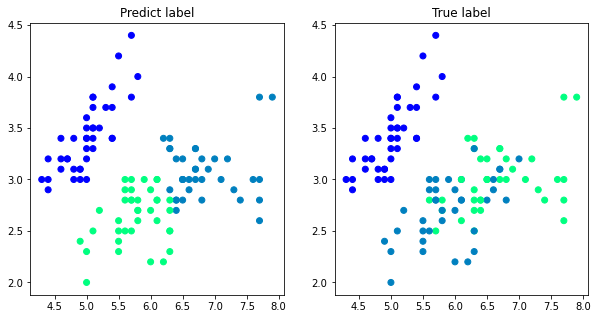

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

model = KMeans(n_clusters=3)
predict = model.fit_predict(X_cluster)

# 조정 랜드지수
print(f'adjusted rand score is {adjusted_rand_score(predict, y_cluster)}\n')

# 예측 분류
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Predict label')
plt.scatter(x=X_cluster.iloc[:, 0],
            y=X_cluster.iloc[:, 1],
            c=predict,
            cmap='winter')

plt.subplot(1, 2, 2)
plt.title('True label')
plt.scatter(x=X_cluster.iloc[:, 0],
            y=X_cluster.iloc[:, 1],
            c=y_cluster,
            cmap='winter')
plt.show()

##### 디비스캔 (DBSCAN)
> DBSCAN은 Density-Based Spatial Clustering of Applications with Noise의 약자로 데이터의 밀도를 기반으로 클러스터링을 한다. K-means와는 다르게 그룹의 갯수를 사용자가 지정할 필요가 없다.

- [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

**유용한 자료**
- [How DBSCAN works and why should we use it? - Towards Data Science](https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80)

adjusted rand score is 0.5776446026524881



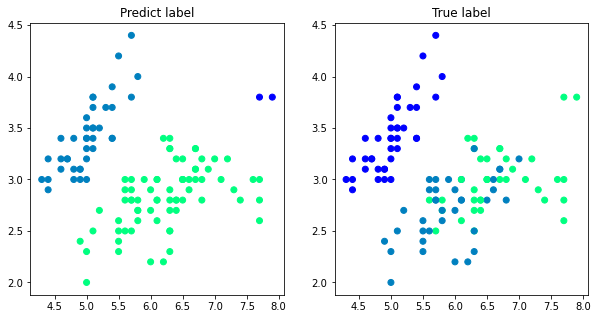

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

model = DBSCAN(eps=0.35, min_samples=3)
predict = model.fit_predict(X_cluster)

# 조정 랜드지수
print(f'adjusted rand score is {adjusted_rand_score(predict, y_cluster)}\n')

# 예측 분류
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Predict label')
plt.scatter(x=X_cluster.iloc[:, 0],
            y=X_cluster.iloc[:, 1],
            c=predict,
            cmap='winter')

plt.subplot(1, 2, 2)
plt.title('True label')
plt.scatter(x=X_cluster.iloc[:, 0],
            y=X_cluster.iloc[:, 1],
            c=y_cluster,
            cmap='winter')
plt.show()

##### 계층적 (Hierachical)
> 모든 데이터가 하나의 그룹을 형성하는 것에서 출발해 서로 가까운 그룹끼리 합쳐지면서 하나의 그룹이 된다. 흩뿌려진 빗방울이 서로간에 합쳐지는 모습을 연상하면 이해가 쉽다.

- [sklearn.cluster.AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

**유용한 자료**
- [Understanding the concept of Hierarchical clustering Technique - Towards Data Science](https://towardsdatascience.com/understanding-the-concept-of-hierarchical-clustering-technique-c6e8243758ec)

adjusted rand score is 0.6008969579857381



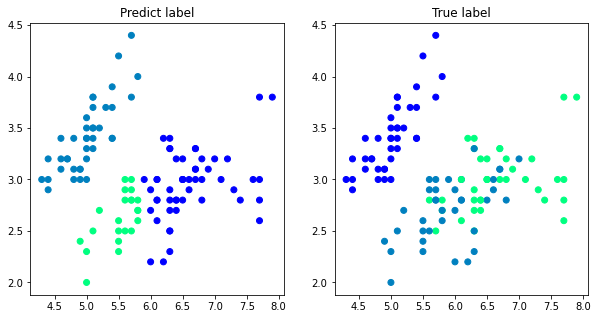

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score

model = AgglomerativeClustering(n_clusters=3)
predict = model.fit_predict(X_cluster)

# 조정 랜드지수
print(f'adjusted rand score is {adjusted_rand_score(predict, y_cluster)}\n')

# 예측 분류
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Predict label')
plt.scatter(x=X_cluster.iloc[:, 0],
            y=X_cluster.iloc[:, 1],
            c=predict,
            cmap='winter')

plt.subplot(1, 2, 2)
plt.title('True label')
plt.scatter(x=X_cluster.iloc[:, 0],
            y=X_cluster.iloc[:, 1],
            c=y_cluster,
            cmap='winter')
plt.show()

#### 2. 차원축소 (Dimension Reduction)

- PCA (Principal Component Analysis)

##### PCA (Principal Component Analysis)

- [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**유용한 자료**
- [차원 축소 - PCA, 주성분분석 - excelsior-chj 티스토리 블로그](https://excelsior-cjh.tistory.com/167)

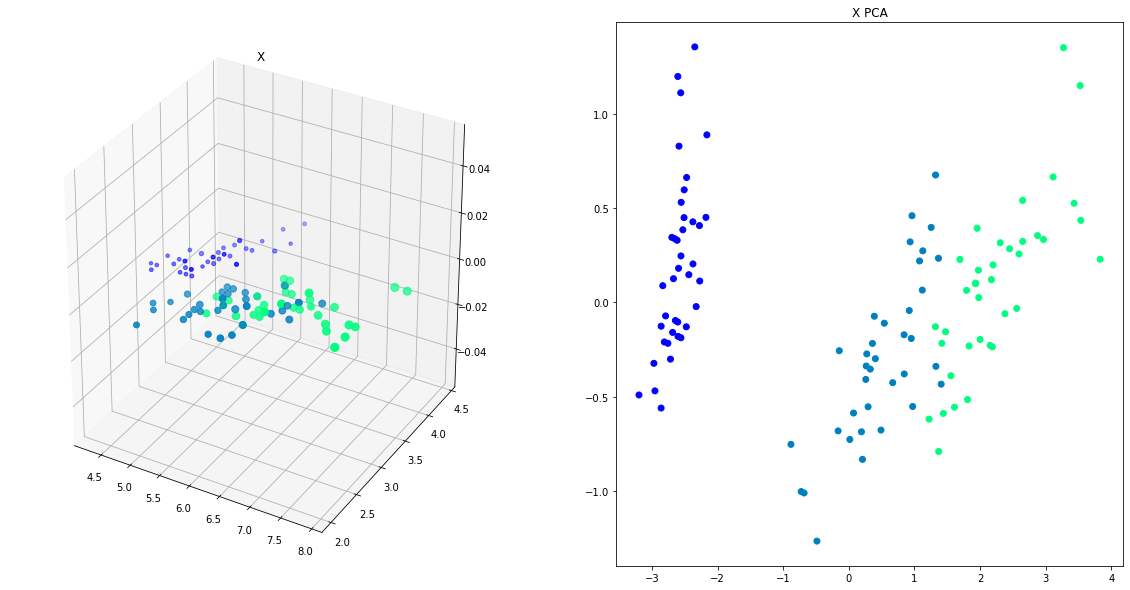

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

model = PCA(n_components=2)
X_pca = model.fit_transform(X_train)

# 시각화
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1, projection='3d')
plt.title('X')
plt.scatter(X_train.iloc[:, 0],
            X_train.iloc[:, 1],
            X_train.iloc[:, 2]*10,
            c=y_train,
            cmap='winter')

plt.subplot(1, 2, 2)
plt.title('X PCA')
plt.scatter(x=X_pca[:, 0],
            y=X_pca[:, 1],
            c=y_train,
            cmap='winter')
plt.show()

#### 3. 다양체 (Manifold)
> PCA와 같은 선형 차원 축소(Dimention Reduction)로는 비선형 데이터를 잘 분리해내지 못한다. 하지만 다양체(manifold)를 찾아서 이를 통한 비선형 변환을 할 경우 복잡한 고차원 데이터를 저차원 데이터로 표현하면서도 데이터의 중요한 정보들을 잘 보존한다.

- Isomap
- t-SNE (t-Stochastic Neightbor Embedding)

**유용한 자료**
- [Manifold learning - sklearn 공식문서](https://scikit-learn.org/stable/modules/manifold.html)
- [Manifolds in Data Science — A Brief Overview - Towards Data Science](https://towardsdatascience.com/manifolds-in-data-science-a-brief-overview-2e9dde9437e5)
- [비선형 차원 축소(Nonliear Mapping) - woosikyang 깃헙 블로그](https://woosikyang.github.io/first-post.html)

##### Isomap

- [sklearn.manifold.Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)

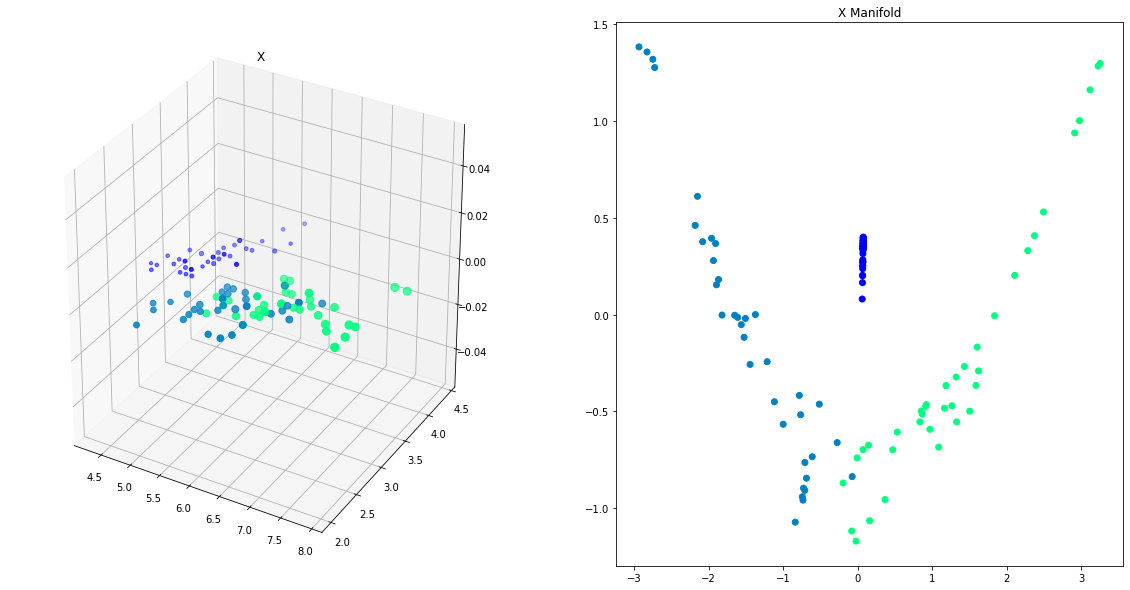

In [ ]:
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D

model = Isomap(n_components=2)
X_manifold = model.fit_transform(X_train)

# 시각화
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1, projection='3d')
plt.title('X')
plt.scatter(X_train.iloc[:, 0],
            X_train.iloc[:, 1],
            X_train.iloc[:, 2]*10,
            c=y_train,
            cmap='winter')

plt.subplot(1, 2, 2)
plt.title('X Manifold')
plt.scatter(x=X_manifold[:, 0],
            y=X_manifold[:, 1],
            c=y_train,
            cmap='winter')
plt.show()

##### t-SNE (t-Stochastic Neightbor Embedding)

- [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

**유용한 자료**
- [Why You Are Using t-SNE Wrong - towardsdatascience](https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0)
- [How to Use t-SNE Effectively
](https://distill.pub/2016/misread-tsne/)


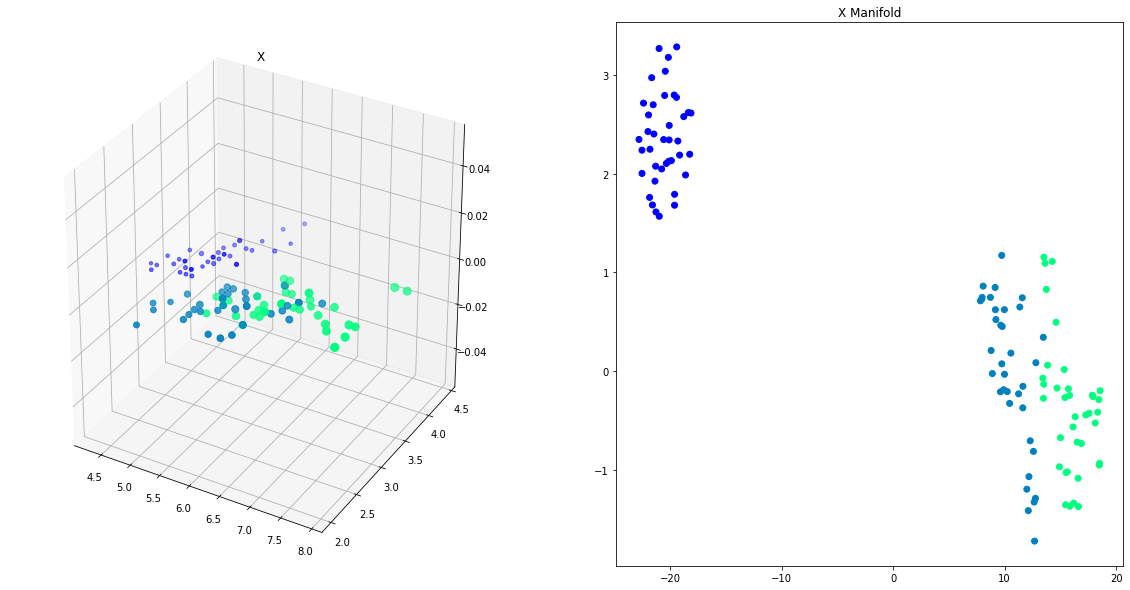

In [ ]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

model = TSNE(n_components=2)
X_manifold = model.fit_transform(X_train)

# 시각화
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1, projection='3d')
plt.title('X')
plt.scatter(X_train.iloc[:, 0],
            X_train.iloc[:, 1],
            X_train.iloc[:, 2]*10,
            c=y_train,
            cmap='winter')

plt.subplot(1, 2, 2)
plt.title('X Manifold')
plt.scatter(x=X_manifold[:, 0],
            y=X_manifold[:, 1],
            c=y_train,
            cmap='winter')
plt.show()


### 💍 앙상블 (Ensemble)

1. 보팅 (Voting)
2. 배깅 (Bagging)
3. 부스팅 (Boosting)
4. 스태킹 (Stacking)

**유용한 자료**
- [Ensemble Learning in Machine Learning | Getting Started - Towards Data Science](https://towardsdatascience.com/ensemble-learning-in-machine-learning-getting-started-4ed85eb38e00)

#### 1. 보팅 (Voting)
> 여러 모델이 의사결정을 내리고 다수의 선택을 최종 선택하는 방법이다

- ⭐ 보팅 (Voting)이 좋은 이유 ⭐
- 하드 보팅 (Hard Voting)
- 소프트 보팅 (Soft Voting)

**유용한 자료**
- [hard voting versus soft voting in ensemble based methods - Stack Exchange](https://stats.stackexchange.com/questions/320156/hard-voting-versus-soft-voting-in-ensemble-based-methods)

##### **⭐ 보팅 (Voting)이 좋은 이유 ⭐**
> 왜 모델 하나보다 모델을 여러개 사용하는 것이 더 좋을까? 각각의 모델이 정답을 출력할 확률을 p로 가정하고, 서로 독립적이고 다른 모델을 N개 모아서 보팅(Voting)을 할 경우 정답을 출력할 확률을 확인해보자.

$$\sum_{k>\frac{N}{2}}^N \binom N k p^k (1-p)^{N-k}$$

**참고자료**
- [모형결합, 모형 결합을 사용한 성능 향상 - 데이터 사이언스 스쿨](https://datascienceschool.net/03%20machine%20learning/12.02%20%EB%AA%A8%ED%98%95%20%EA%B2%B0%ED%95%A9.html)

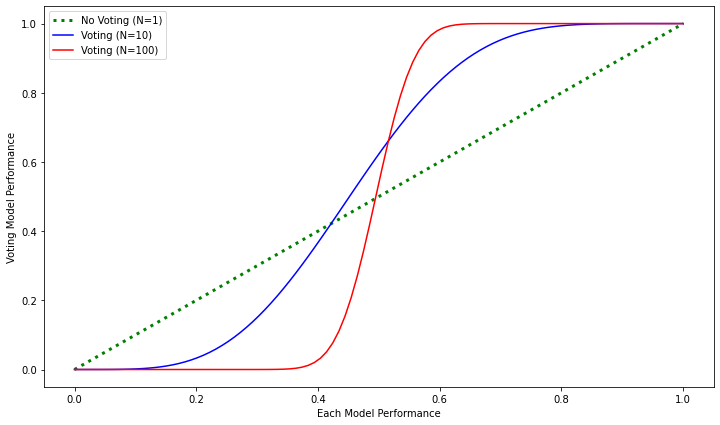

In [ ]:
# 출처 - https://datascienceschool.net/03%20machine%20learning/12.02%20%EB%AA%A8%ED%98%95%20%EA%B2%B0%ED%95%A9.html
from scipy.special import comb

def total_correct(p, N):
    correct_prob = 0.0

    # 모델 중 최소 절반 이상이 정답을 맞출 확률
    for k in range(int(np.ceil(N/2)), N + 1):
        correct_prob += comb(N, k) * p**k * (1-p)**(N-k)
    return correct_prob

p = np.linspace(0, 1, 100)

plt.figure(figsize=(12, 7))
plt.plot(p, p, 'g:', lw=3, label="No Voting (N=1)")
plt.plot(p, total_correct(p, 10), 'b-', label="Voting (N=10)")
plt.plot(p, total_correct(p, 100), 'r-', label="Voting (N=100)")
plt.xlabel("Each Model Performance")
plt.ylabel("Voting Model Performance")
plt.legend(loc=0)
plt.show()

##### 하드 보팅 (Hard Voting)

```python
VotingClassifier(estimators=[('model_name', model), ... ], voting='hard')
```

- [sklearn.ensemble.VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# model 1 - 로지스틱 회귀
model = LogisticRegression().fit(X_train, y_train)
predict = model.predict(X_test)
logistic_score = accuracy_score(y_test, predict)

# model 2 - 의사결정나무
model = DecisionTreeClassifier().fit(X_train, y_train)
predict = model.predict(X_test)
tree_score = accuracy_score(y_test, predict)

# model 3 - 가우시안 나이브 베이즈
model = GaussianNB().fit(X_train, y_train)
predict = model.predict(X_test)
naive_score = accuracy_score(y_test, predict)

# 하드 보팅
logistic = LogisticRegression()
tree = DecisionTreeClassifier()
naive = GaussianNB()

estimators = [('logistic', logistic),
              ('tree', tree),
              ('naive', naive)]
hard_vote = VotingClassifier(estimators=estimators, voting='hard')
hard_vote.fit(X_train, y_train)
predict = hard_vote.predict(X_test)
hard_vote_score = accuracy_score(y_test, predict)

print(f"Logistic Regression accuracy : {logistic_score}")
print(f"Decision Tree accuracy : {tree_score}")
print(f"naive accuracy : {naive_score}")
print(f"Hard Voting of 3 model accuracy : {hard_vote_score}")

Logistic Regression accuracy : 0.8947368421052632
Decision Tree accuracy : 0.8947368421052632
naive accuracy : 0.868421052631579
Hard Voting of 3 model accuracy : 0.8947368421052632


##### 소프트 보팅 (Soft Voting)

```python
VotingClassifier(estimators=[('model_name', model), ... ], voting='soft')
```

- [sklearn.ensemble.VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# model 1 - 로지스틱 회귀
model = LogisticRegression().fit(X_train, y_train)
predict = model.predict(X_test)
logistic_score = accuracy_score(y_test, predict)

# model 2 - 의사결정나무
model = DecisionTreeClassifier().fit(X_train, y_train)
predict = model.predict(X_test)
tree_score = accuracy_score(y_test, predict)

# model 3 - 가우시안 나이브 베이즈
model = GaussianNB().fit(X_train, y_train)
predict = model.predict(X_test)
naive_score = accuracy_score(y_test, predict)

# 소프트 보팅
logistic = LogisticRegression()
tree = DecisionTreeClassifier()
naive = GaussianNB()

estimators = [('logistic', logistic),
              ('tree', tree),
              ('naive', naive)]
soft_vote = VotingClassifier(estimators=estimators, voting='soft')
soft_vote.fit(X_train, y_train)
predict = soft_vote.predict(X_test)
soft_vote_score = accuracy_score(y_test, predict)

print(f"Logistic Regression accuracy : {logistic_score}")
print(f"Decision Tree accuracy : {tree_score}")
print(f"naive accuracy : {naive_score}")
print(f"Soft Voting of 3 model accuracy : {soft_vote_score}")

Logistic Regression accuracy : 0.8947368421052632
Decision Tree accuracy : 0.9210526315789473
naive accuracy : 0.868421052631579
Soft Voting of 3 model accuracy : 0.8947368421052632


#### 2. 배깅 (Bagging)

> 투표(voting) 방식을 사용할 때 서로 다른 모델들을 사용하기에는 모델 종류에 한계가 존재한다. 하지만 그렇다고 같은 모델을 사용한다면 모델간의 독립성이 보장되지 않는다. 그래서 같은 모델을 사용하되 데이터셋에서 데이터를 랜덤하게 선택하여 서로 다른 모델을 여러개 만들어 투표(voting)로 최종 결정을 내린다.

⭐ 데이터 랜덤 선택 방법 ⭐
> 부트스트래핑(Bootstrapping)과 비슷하게 데이터를 선택한다. 이때 데이터셋의 샘플(sample) 혹은 feature를 랜덤하게 선택할 수 있고, 샘플(sample) 선택시 중복을 허용하거나 허용하지 않을수도 있다.
- 배깅 (Bagging) : 같은 데이터 샘플 중복사용(replacement)
- 패스팅 (Pasting) : 같은 데이터 샘플 중복사용(replacement) 안함  
- 랜덤 부분공간 (Random Subspace) : feature들 중 일부만 사용
- 랜덤 패치 (Random Patches) : 데이터 & feature 둘다 일부만 사용

- 배깅 분류기 (Bagging Classifier)
- 랜덤 포레스트 (Random Forest)
- 엑스트라 트리 (Extra Tree)

**참고 자료**
- [모형결합, 배깅 - 데이터 사이언스 스쿨](https://datascienceschool.net/03%20machine%20learning/12.02%20%EB%AA%A8%ED%98%95%20%EA%B2%B0%ED%95%A9.html)

**유용한 자료**
- [How does ExtraTreesClassifier reduce the risk of overfitting? - Medium](https://medium.com/@namanbhandari/extratreesclassifier-8e7fc0502c7)

##### 배깅 분류기 (Bagging Classifier)
> 배깅 분류기(Bagging Classifier)를 이용해 다음의 4가지 데이터 선택법을 사용해보자!

- 배깅 (Bagging)
- 패스팅 (Pasting)
- 랜덤 부분공간 (Random Subspace)
- 랜덤 패치 (Random Patches)


- [sklearn.ensemble.BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# 랜덤 seed
random_seed = 42

# 배깅 (Bagging) : 같은 데이터 샘플 중복사용(replacement)
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=50),
                            n_estimators=100,
                            bootstrap=True,
                            max_samples=0.5,
                            bootstrap_features=False,
                            max_features=1.0,
                            random_state=random_seed)

# 패스팅 (Pasting) : 같은 데이터 샘플 중복사용(replacement) 안함
pasting = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=50),
                            n_estimators=100,
                            bootstrap=False,
                            max_samples=0.5,
                            bootstrap_features=False,
                            max_features=1.0,
                            random_state=random_seed)

# 랜덤 부분공간 (Random Subspace) : feature들 중 일부만 사용
subspace = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=50),
                             n_estimators=100,
                             bootstrap=False,
                             max_samples=1.0,
                             bootstrap_features=True,
                             max_features=0.5,
                             random_state=random_seed)

# 랜덤 패치 (Random Patches) : 데이터 & feature 둘다 일부만 사용
patch = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=50),
                          n_estimators=100,
                          bootstrap=True,
                          max_samples=0.5,
                          bootstrap_features=True,
                          max_features=0.5,
                          random_state=random_seed)

model_types = ['bagging', 'pasting', 'random subspace', 'random patches']
models = [bagging, pasting, subspace, patch]

predicts = []
for model in models:
    model.fit(X_train, y_train)
    predicts.append(model.predict(X_test))

for model_type, predict in zip(model_types, predicts):
    score = accuracy_score(y_test, predict)
    print(f'{model_type} accuracy : {score}')

bagging accuracy : 0.9210526315789473
pasting accuracy : 0.8947368421052632
random subspace accuracy : 0.9210526315789473
random patches accuracy : 0.8947368421052632


**랜덤 패치 (Random Patches)**
> 데이터 & feature 둘다 일부만 사용

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier



model.fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.8947368421052632

##### 랜덤 포레스트 (Random Forest)
> 랜덤 부분공간(Random Subspace)를 사용하여 트리(Tree)를 여러개 만든다. 다시 말해 트리 모델을 하나 추가할때마다 사용할 feature들을 랜덤으로 선택한다.
- [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.8947368421052632

##### 엑스트라 트리 (Extra Tree)

> 랜덤 포레스트에서 동일한 feature들을 포함하는 2개 이상의 모델들의 greedy한 의사결정에 의해 서로간에 상관관계가 강한 모델들이 나온다.<br><br>
**이를 방지하기 위해 랜덤하게 feature들을 선택하는 과정인 랜덤 부분공간(Random Subspace) 을 모델마다가 아니라 노드마다 시행하며, 여기에서 선택된 feature들 중에서 분류 기준으로 사용할 feature를 랜덤하게 선택**한다. 이를 `익스트림 랜덤 트리(Extremely Randomized Tree)`라고 부르기도 한다.

- [sklearn.ensemble.ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

model = ExtraTreesClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.8947368421052632

#### 3. 부스팅 (Boosting)
> 보팅(Voting)의 경우 모델간의 독립성이 중요하다. 하지만 부스팅(Boosting)의 경우 모델은 서로 독립이 아니다. 서로가 서로의 부족한 면을 채워줌으로서 더 나은 결정을 내리고자 하며 성능 분산(Variance)를 줄이는 배깅(Bagging)과는 다르게 편향(Bias)을 줄인다.

- 에이다 부스트 (AdaBoost)
- 그래디언트 부스트 (Gradient Boost)

**⭐ 베이스 모델 ⭐**
> **의사결정나무(Decision Tree)가 부스팅 앙상블에서 베이스 모델로 가장 자주 사용된다**
- `에이다 부스트 (AdaBoost)` : 깊이가 1인 의사결정나무가 default이며 다른 모델을 사용할 수 있다.
- `그래디언트 부스트 (Gradient Boost)` : ⛔ **의사결정나무"만" 사용된다!** ⛔

**유용한 자료**
- [A Quick Guide to Boosting in ML - Medium](https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5)


##### 에이다 부스트 (AdaBoost)
> 이전에 생성되었던 모델들이 잘 맞추는 데이터는 학습시 가중치를 덜 주고, 못 맞추는 데이터는 학습시 가중치를 더 부여하는 방식으로 다음 모델을 순차적으로 만들어 다함께 활용한다. 여기서 생성된 모델들의 집합을 가리켜 committee라고 하며 다음 모델을 학습할 때 어떤 데이터에 가중치를 더 주고 조금 줄지는 그 전까지 생성되었던 모델들의 집합인 committee에서 어떤 데이터를 맞추고 못맞추느냐로 결정된다.

- [sklearn.ensemble.AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

**유용한 자료**
- [The Ultimate Guide to AdaBoost Algorithm | What is AdaBoost Algorithm? - Great Learning](https://www.mygreatlearning.com/blog/adaboost-algorithm/)
- [Adaboost(에이다부스트) - ekdud7667 티스토리 블로그](https://ekdud7667.tistory.com/entry/Adaboost%EC%97%90%EC%9D%B4%EB%8B%A4%EB%B6%80%EC%8A%A4%ED%8A%B8)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

model = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.9473684210526315

##### 그래디언트 부스트 (Gradient Boost)
> 이전에 생성되었던 모델들이 예측한 값과 실제 값의 차이인 잔차(residual)를 학습하는 방식으로 다음 모델을 순차적으로 만들어 다함께 활용한다. 다음 모델을 학습할 때 사용할 각 데이터의 잔차(residual)는 그 전까지 생성되었던 모델들의 집합인 committee에서 예측한 값과 실제 값의 차이다.

- 그래디언트 부스팅 분류기 (Gradient Boosting Classifier)
- XGBoost (Extreme Gradient Boosting)
- LGBM (Light Gradient Boosting Machine)
- CatBoost (Categorical Boost)


**유용한 자료**
- [Demystifying gradient boosting - Towards Data Science](https://towardsdatascience.com/simplifying-gradient-boosting-5dcd934e9c76)
- [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning - Machine Learing Mastery](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
- [CatBoost vs. Light GBM vs. XGBoost - Towards Data Science](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
- [XGBoost, LightGBM or CatBoost — which boosting algorithm should I use? - Medium](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc)

###### 그래디언트 부스팅 분류기 (Gradient Boosting Classifier)


- [sklearn.ensemble.GradientBoostingClassifier
](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boost#sklearn.ensemble.GradientBoostingClassifier)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

model = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.868421052631579

###### XGBoost (Extreme Gradient Boosting)

**유용한 자료**
- [XGBoost Algorithm: Long May She Reign! - Towards Data Science](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.868421052631579

###### LGBM (Light Gradient Boosting Machine)

**유용한 자료**
- [A Quick Guide to the LightGBM Library - Towards Data Science](https://towardsdatascience.com/a-quick-guide-to-lightgbm-library-ef5385db8d10)
- [What is LightGBM, How to implement it? How to fine tune the parameters? - Medium](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

model = LGBMClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.868421052631579

###### CatBoost (Categorical Boost)

**유용한 자료**
- [Mastering The New Generation of Gradient Boosting - Towards Data Science](https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2)

In [ ]:
!pip install -q catboost

     |████████████████████████████████| 67.3MB 55kB/s 


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

model = CatBoostClassifier(verbose=False).fit(X_train, y_train)
predict = model.predict(X_test)

accuracy_score(y_test, predict)

0.8947368421052632

#### 4. 스태킹 (Stacking)

- OOF (Out Of Fold) Stacking



##### OOF (Out Of Fold) Stacking
> KFold에서 각 Fold마다 train set을 활용하여 모델을 훈련시키고 validation set을 예측한 값을 모두 모아서 합치면 이를 OOf(Out Of Fold)라고 부른다. 모델마다 하나의 OOF를 생성할 수 있는데 모델들이 생성한 OOF들을 모두 모아서(Stacking) 이 데이터를 활용해 meta learning을 하는 것을 `OOF (Out Of Fold) Stacking`이라고 부른다.

- 머신러닝을 위한 `vecstack` 라이브러리
- 딥러닝을 위한 `oof stacking ensemble class` 구축


**유용한 자료**
- [What is OOF approach in machine learning? - Stack Overflow](https://stackoverflow.com/questions/52396191/what-is-oof-approach-in-machine-learning)


###### 머신러닝을 위한 `vecstack` 라이브러리
> 머신러닝 모델을 사용하여 **oof stacking**을 한다면 `vecstack`라이브러리를 활용하여 매우 간단하게 할 수 있다

**유용한 자료**
- [Automate Stacking In Python - Towards Data Science](https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e)

In [ ]:
!pip install -q vecstack

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from vecstack import stacking


### xgboost 단일 모델
model = XGBClassifier().fit(X_train, y_train)
predict = model.predict(X_test)

single_score = accuracy_score(y_test, predict)


# 출처 - https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e
### oof stacking
models = [KNeighborsClassifier(),
          RandomForestClassifier(),
          XGBClassifier()]

# 1st level training
S_train, S_test = stacking(models, X_train, y_train, X_test,
                           n_folds=5, stratified=True, shuffle=True)

# 2nd level training
meta_model = XGBClassifier(n_estimators=100, max_depth=3)
meta_model.fit(S_train, y_train)

predict = meta_model.predict(S_test)
stack_score = accuracy_score(y_test, predict)


### result
print(f"xgboost single model score : {single_score}")
print(f"5 fold oof stacking score : {stack_score}")

xgboost single model score : 0.868421052631579
5 fold oof stacking score : 0.9210526315789473


###### 딥러닝을 위한 `oof stacking ensemble class` 구축
> 딥러닝 모델을 위한 **oof stacking**을 할 경우 직접 class를 구축해서 편리하게 사용할 수 있다. 다음의 5가지 단계별로 차근차근 구현해보자!

1. 딥러닝 모델 훈련 및 검증용 클래스
2. oof 함수
3. oof stacking 함수
4. meta training 및 test 함수
5. stacking 클래스

In [ ]:
class NN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear1 = nn.Linear(4, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x = self.linear1(x)
        outputs = self.linear2(x)
        return outputs

**1. 딥러닝 모델 훈련 및 검증용 클래스**
> args와 데이터를 바탕으로 모델을 훈련시켜 출력한다
<br><br>
확장성을 위해 데이터셋이나 모델이 변화하는 경우에 가능한 이 함수만 수정하게 하고 나머지 oof 관련 함수들은 수정 없이 사용될 수 있도록 만들자. 추가적으로 evaluate, test기능도 지원하게 하자.

In [ ]:
class Trainer:
    def __init__(self):
        pass

    def get_model(self):
        if self.args['model'] == 'nn':
            return NN(self.args['hidden_size'])

    def train(self, args, X_train, y_train, X_valid, y_valid):

        # args update
        self.args = args
        model = self.get_model()

        # 데이터 타입 변화 pandas.DataFrame -> torch.tensor
        X_train = torch.from_numpy(X_train.to_numpy())
        y_train = torch.from_numpy(y_train.to_numpy())

        trainset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

        for epoch in range(5):
        
            for batch in train_loader:
                
                X_batch, y_batch = batch
                X_batch = X_batch.to(torch.float32)
                y_batch = y_batch.to(torch.long)

                if torch.cuda.is_available():
                    model.to('cuda')
                    X_batch = X_batch.to('cuda')
                    y_batch = y_batch.to('cuda')
                
                predict = model(X_batch)

                loss = F.cross_entropy(predict, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        return model

    def evaluate(self, model, X_valid):

        # 데이터 타입 변화 pandas.DataFrame -> torch.tensor
        X_valid = torch.from_numpy(X_valid.to_numpy()).to(torch.float32)
        if torch.cuda.is_available():
            X_valid = X_valid.to('cuda')

        output = model(X_valid)
        output = F.softmax(output)
        _, predict = torch.max(output, 1)

        return predict

    def test(self, model, X_test):
        return self.evaluate(model, X_test)

In [ ]:
args = {'model': 'nn', 'hidden_size': 8}

trainer = Trainer()
trained_model = trainer.train(args, X_train, y_train, None, None)
trained_model

NN(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=3, bias=True)
)

**2. oof 함수**
> args와 데이터를 입력받으면 oof를 출력하는 함수를 만들어보자!
<br><br>
Train셋과 Test셋이 함께 주어질 경우 별도로 만들 필요가 없지만 보통은 따로 주어지기 때문에 Train셋에서 모델을 먼저 훈련하고 oof를 출력하는 함수를 만들고, 추후에 Test셋이 주어지면 Train셋에서 훈련한 모델을 이용해 KFold 평균값을 출력하는 함수를 별도로 만든다.

- [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)


![OOF](https://github.com/IllgamhoDuck/ML_Pipeline/blob/main/images/OOF.png?raw=true)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_train_oof(args, X, y, fold_n=5, stratify=True):

    oof = np.zeros(X.values.shape[0])
    oof = torch.tensor(oof)
    if torch.cuda.is_available():
        oof = oof.to('cuda')

    fold_models = []

    if stratify:
        kfold = StratifiedKFold(n_splits=fold_n)
    else:
        kfold = KFold(n_splits=fold_n)

    # 클래스 비율 고려하여 Fold별로 데이터 나눔
    for train_index, valid_index in kfold.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # 모델 생성 및 훈련
        trainer = Trainer()
        trained_model = trainer.train(args, X_train, y_train, None, None)

        # 모델 검증
        predict = trainer.evaluate(trained_model, X_valid)
        
        # fold별 oof 값 모으기
        oof[valid_index] = predict.to(torch.double)
        fold_models.append(trained_model)

    return oof, fold_models

In [ ]:
def get_test_avg(models, X):

    predicts = np.zeros(X.values.shape[0])
    predicts = torch.tensor(predicts)
    if torch.cuda.is_available():
        predicts = predicts.to('cuda')

    # 클래스 비율 고려하여 Fold별로 데이터 나눔
    for model in models:
        
        trainer = Trainer()
        predict = trainer.test(model, X)
        
        # fold별 prediction 값 모으기
        predicts += predict

    # prediction들의 average 계산
    predict_avg = predicts / len(models)

    return predict_avg

In [ ]:
args = {'model': 'nn', 'hidden_size': 8}

train_oof, models = get_train_oof(args, X_train, y_train)
test_avg = get_test_avg(models, X_test)

print(f"train_oof : {train_oof}")
print(f"test_avg : {test_avg}")

train_oof : tensor([0., 2., 2., 2., 2., 2., 1., 0., 1., 1., 2., 0., 0., 0., 2., 0., 2., 1.,
        1., 2., 0., 0., 0., 1., 2., 1., 1., 0., 2., 0., 0., 2., 2., 0., 2., 0.,
        1., 2., 1., 0., 1., 0., 2., 2., 1., 0., 0., 1., 2., 0., 1., 2., 1., 0.,
        0., 0., 2., 2., 0., 0., 2., 1., 1., 2., 1., 0., 0., 2., 0., 0., 1., 2.,
        2., 1., 1., 0., 1., 0., 0., 1., 1., 2., 0., 1., 1., 1., 2., 1., 2., 0.,
        1., 1., 0., 0., 0., 1., 1., 0., 2., 2., 2., 2., 0., 2., 1., 2., 0., 2.,
        1., 2., 1., 0.], dtype=torch.float64)
test_avg : tensor([1.8000, 1.2000, 0.0000, 1.2000, 2.0000, 0.0000, 1.0000, 1.2000, 0.0000,
        1.0000, 1.2000, 1.0000, 0.0000, 2.0000, 0.0000, 1.8000, 2.0000, 1.8000,
        0.0000, 0.0000, 1.0000, 2.0000, 1.2000, 1.8000, 1.6000, 1.8000, 1.0000,
        1.0000, 2.0000, 2.0000, 1.6000, 0.8000, 0.0000, 1.8000, 1.0000, 0.0000,
        0.0000, 0.0000], dtype=torch.float64)


**3. oof stacking 함수**

> args 리스트와 데이터를 입력하면 훈련된 모델들과 oof stacking 데이터를 출력하는 함수를 만들어보자! 여기서 args_list란 각 모델의 args를 모아놓은 리스트를 말한다.


![OOF STACKING](https://github.com/IllgamhoDuck/ML_Pipeline/blob/main/images/oof%20stacking.png?raw=true)

In [ ]:
def train_oof_stacking(args_list, X, y, fold_n=5, stratify=True):
    
    S_train = None
    models_list = []
    for args in args_list:
        train_oof, models = get_train_oof(args, X, y, fold_n=fold_n, stratify=stratify)

        # torch.tensor -> np.ndarray
        train_oof = train_oof.cpu().numpy()
        train_oof = train_oof.reshape(-1, 1)

        # oof stack!
        if not isinstance(S_train, np.ndarray):
            S_train = train_oof
        else:
            S_train = np.concatenate([S_train, train_oof], axis=1)

        # store fold models
        models_list.append(models)

    return models_list, S_train


In [ ]:
def test_avg_stacking(models_list, X):
    
    S_test = None
    for models in models_list:
        test_avg = get_test_avg(models, X)

        # torch.tensor -> np.ndarray
        test_avg = test_avg.cpu().numpy()
        test_avg = test_avg.reshape(-1, 1)

        # avg stack!
        if not isinstance(S_test, np.ndarray):
            S_test = test_avg
        else:
            S_test = np.concatenate([S_test, test_avg], axis=1)

    return S_test

In [ ]:
# 5개의 모델 테스트
args_list = [{'model': 'nn', 'hidden_size': 2},
             {'model': 'nn', 'hidden_size': 4},
             {'model': 'nn', 'hidden_size': 8},
             {'model': 'nn', 'hidden_size': 16},
             {'model': 'nn', 'hidden_size': 32}]

models_list, S_train = train_oof_stacking(args_list, X_train, y_train)
S_test = test_avg_stacking(models_list, X_test)

print(f"oof stacking for train : {S_train.shape}")
print(f"avg stacking for test : {S_test.shape}")

oof stacking for train : (112, 5)
avg stacking for test : (38, 5)


In [ ]:
models_list

[[NN(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=3, bias=True)
  ), NN(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=3, bias=True)
  ), NN(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=3, bias=True)
  ), NN(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=3, bias=True)
  ), NN(
    (linear1): Linear(in_features=4, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=3, bias=True)
  )], [NN(
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=3, bias=True)
  ), NN(
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=3, bias=True)
  ), NN(
    (linear1): Linear(in_features

**4. meta training 및 test 함수**
> oof stacking 데이터가 모두 마련되었으면 이를 바탕으로 meta training 및 test를 하는 함수를 만들어보자!

In [ ]:
def train(meta_model, args_list, X, y):
    models_list, S_train = train_oof_stacking(args_list, X, y)
    meta_model.fit(S_train, y)
    
    return meta_model, models_list

In [ ]:
def test(meta_model, models_list, X):
    S_test = test_avg_stacking(models_list, X)
    predict = meta_model.predict(S_test)

    return predict

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

meta_model = XGBClassifier(n_estimators=100, max_depth=3)
args_list = [{'model': 'nn', 'hidden_size': 2},
             {'model': 'nn', 'hidden_size': 4},
             {'model': 'nn', 'hidden_size': 8},
             {'model': 'nn', 'hidden_size': 16},
             {'model': 'nn', 'hidden_size': 32}]

# oof stacking ensemble
meta_model, models_list = train(meta_model, args_list, X_train, y_train)
predict = test(meta_model, models_list, X_test)

stack_score = accuracy_score(y_test, predict.cpu())

In [ ]:
args = {'model': 'nn', 'hidden_size': 8}

# single model
trainer = Trainer()
trained_model = trainer.train(args, X_train, y_train, None, None)
predict = trainer.test(trained_model, X_test)

single_score = accuracy_score(y_test, predict.cp)

In [ ]:
### result
print(f"single model score : {single_score}")
print(f"5 fold oof stacking score : {stack_score}")

single model score : 0.8157894736842105
5 fold oof stacking score : 0.9210526315789473


**5. stacking 클래스**
> 위에서 만든 모든 oof stacking 관련 함수들을 하나로 모은 클래스를 만들자! 이를 바탕으로 우리는 우리만의 oof stacking ensemble 라이브러리를 가지게 된다!

In [ ]:
class Stacking:
    def __init__(self, trainer):
        self.trainer = trainer



    def get_train_oof(self, args, X, y, fold_n=5, stratify=True):

        oof = np.zeros(X.values.shape[0])
        oof = torch.tensor(oof)
        if torch.cuda.is_available():
            oof = oof.to('cuda')

        fold_models = []

        if stratify:
            kfold = StratifiedKFold(n_splits=fold_n)
        else:
            kfold = KFold(n_splits=fold_n)

        # 클래스 비율 고려하여 Fold별로 데이터 나눔
        for train_index, valid_index in kfold.split(X, y):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # 모델 생성 및 훈련
            trained_model = self.trainer.train(args, X_train, y_train, None, None)

            # 모델 검증
            predict = self.trainer.evaluate(trained_model, X_valid)
            
            # fold별 oof 값 모으기
            oof[valid_index] = predict.to(torch.double)
            fold_models.append(trained_model)

        return oof, fold_models

    def get_test_avg(self, models, X):

        predicts = np.zeros(X.values.shape[0])
        predicts = torch.tensor(predicts)
        if torch.cuda.is_available():
            predicts = predicts.to('cuda')

        # 클래스 비율 고려하여 Fold별로 데이터 나눔
        for model in models:
            predict = self.trainer.test(model, X)
            
            # fold별 prediction 값 모으기
            predicts += predict

        # prediction들의 average 계산
        predict_avg = predicts / len(models)

        return predict_avg



    def train_oof_stacking(self, args_list, X, y, fold_n=5, stratify=True):
    
        S_train = None
        models_list = []
        for args in args_list:
            train_oof, models = self.get_train_oof(args, X, y, fold_n=fold_n, stratify=stratify)

            # torch.tensor -> np.ndarray
            train_oof = train_oof.cpu().numpy()
            train_oof = train_oof.reshape(-1, 1)

            # oof stack!
            if not isinstance(S_train, np.ndarray):
                S_train = train_oof
            else:
                S_train = np.concatenate([S_train, train_oof], axis=1)

            # store fold models
            models_list.append(models)

        return models_list, S_train

    def test_avg_stacking(self, models_list, X):
    
        S_test = None
        for models in models_list:
            test_avg = self.get_test_avg(models, X)

            # torch.tensor -> np.ndarray
            test_avg = test_avg.cpu().numpy()
            test_avg = test_avg.reshape(-1, 1)

            # avg stack!
            if not isinstance(S_test, np.ndarray):
                S_test = test_avg
            else:
                S_test = np.concatenate([S_test, test_avg], axis=1)

        return S_test



    def train(self, meta_model, args_list, X, y):
        models_list, S_train = self.train_oof_stacking(args_list, X, y)
        meta_model.fit(S_train, y)
        
        return meta_model, models_list

    def test(self, meta_model, models_list, X):
        S_test = self.test_avg_stacking(models_list, X)
        predict = meta_model.predict(S_test)

        return predict


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

meta_model = XGBClassifier(n_estimators=100, max_depth=3)
args_list = [{'model': 'nn', 'hidden_size': 2},
             {'model': 'nn', 'hidden_size': 4},
             {'model': 'nn', 'hidden_size': 8},
             {'model': 'nn', 'hidden_size': 16},
             {'model': 'nn', 'hidden_size': 32}]

# oof stacking ensemble
# Train
stacking = Stacking(Trainer())
meta_model, models_list = stacking.train(meta_model, args_list, X_train, y_train)

# Test
stacking = Stacking(Trainer())
predict = stacking.test(meta_model, models_list, X_test)

stack_score = accuracy_score(y_test, predict)

In [ ]:
args = {'model': 'nn', 'hidden_size': 8}

# single model
trainer = Trainer()
trained_model = trainer.train(args, X_train, y_train, None, None)
predict = trainer.test(trained_model, X_test)

single_score = accuracy_score(y_test, predict)

In [ ]:
### result
print(f"single model score : {single_score}")
print(f"5 fold oof stacking score : {stack_score}")

single model score : 0.8157894736842105
5 fold oof stacking score : 0.9210526315789473


이제 우리는 다음과 같은 과정으로 `Stacking` 클래스를 사용할 수 있다.

1. `Trainer`를 사용하면서 최적의 `args`를 찾아나간다
2. 찾은 `args`를 `args_list`로 차곡차곡 정리한다
3. **Train**단계에서 `args_list`를 활용해 meta모델과 1차 모델들을 훈련한 후 이를 저장한다
4. **Test**단계에서 저장한 meta모델과 1차 모델들을 불러와 이를 이용해 결과값을 도출한다